In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

2023-02-09 10:34:37.806395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 10:34:38.464914: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-09 10:34:39.672371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/leo/anaconda3/lib/
2023-02-09 10:34:39.672493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [2]:
sys.path.append(os.path.abspath(os.path.join('../../..')))
from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/leo/Workspace/BayesFlow/bayesflow/trainers.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
def model_prior():
    """Generates random draws from uniform pior"""
    sample = np.random.uniform(low=[0, 0, -1, -1, -1, -1], high=[1, 1, 1, 1, 1, 1], size=6)
    return sample

prior = Prior(prior_fun=model_prior, param_names=[r'$D_u$', r'$D_v$', r'$\gamma_u$', r'$\alpha_u$', r'$\gamma_v$', r'$\alpha_v$'])
prior_means, prior_stds = prior.estimate_means_and_stds()

In [4]:
def PDE_solver(params, t, x):
    """PDE Numeric Solver"""
    nr = len(x)
    U0 = params[2] * np.sin(params[3] * x)
    V0 = params[4] * np.cos(params[5] * x)
    X0 = np.concatenate((U0, V0))
    
    def diffusion_pde(X, t):
        diff_matrix = (
                np.diag(np.full(nr, -2))
                + np.diag(np.ones(nr - 1), 1)
                + np.diag(np.ones(nr - 1), -1)
                + np.diag(np.ones(1), nr - 1)
                + np.diag(np.ones(1), 1 - nr)
        )

        zero_matrix = np.zeros((nr, nr))
        
        Du_matrix = params[0] * diff_matrix
        Dv_matrix = params[1] * diff_matrix
        
        Du_matrix_zero = np.concatenate((Du_matrix, zero_matrix), axis=1)
        Dv_matrix_zero = np.concatenate((zero_matrix, Dv_matrix), axis=1)
        
        D_matrix = np.concatenate((Du_matrix_zero, Dv_matrix_zero), axis=0)
        
        return D_matrix @ X
    
    return odeint(diffusion_pde, X0, t)
    
        
t = np.linspace(0, 5, num=20)
x = np.linspace(0, 10, 10)

simulator = Simulator(simulator_fun=partial(PDE_solver, t=t, x=x))
model = GenerativeModel(prior, simulator, name='PDE_generator')    

INFO:root:Performing 2 pilot runs with the PDE_generator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 20, 20)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


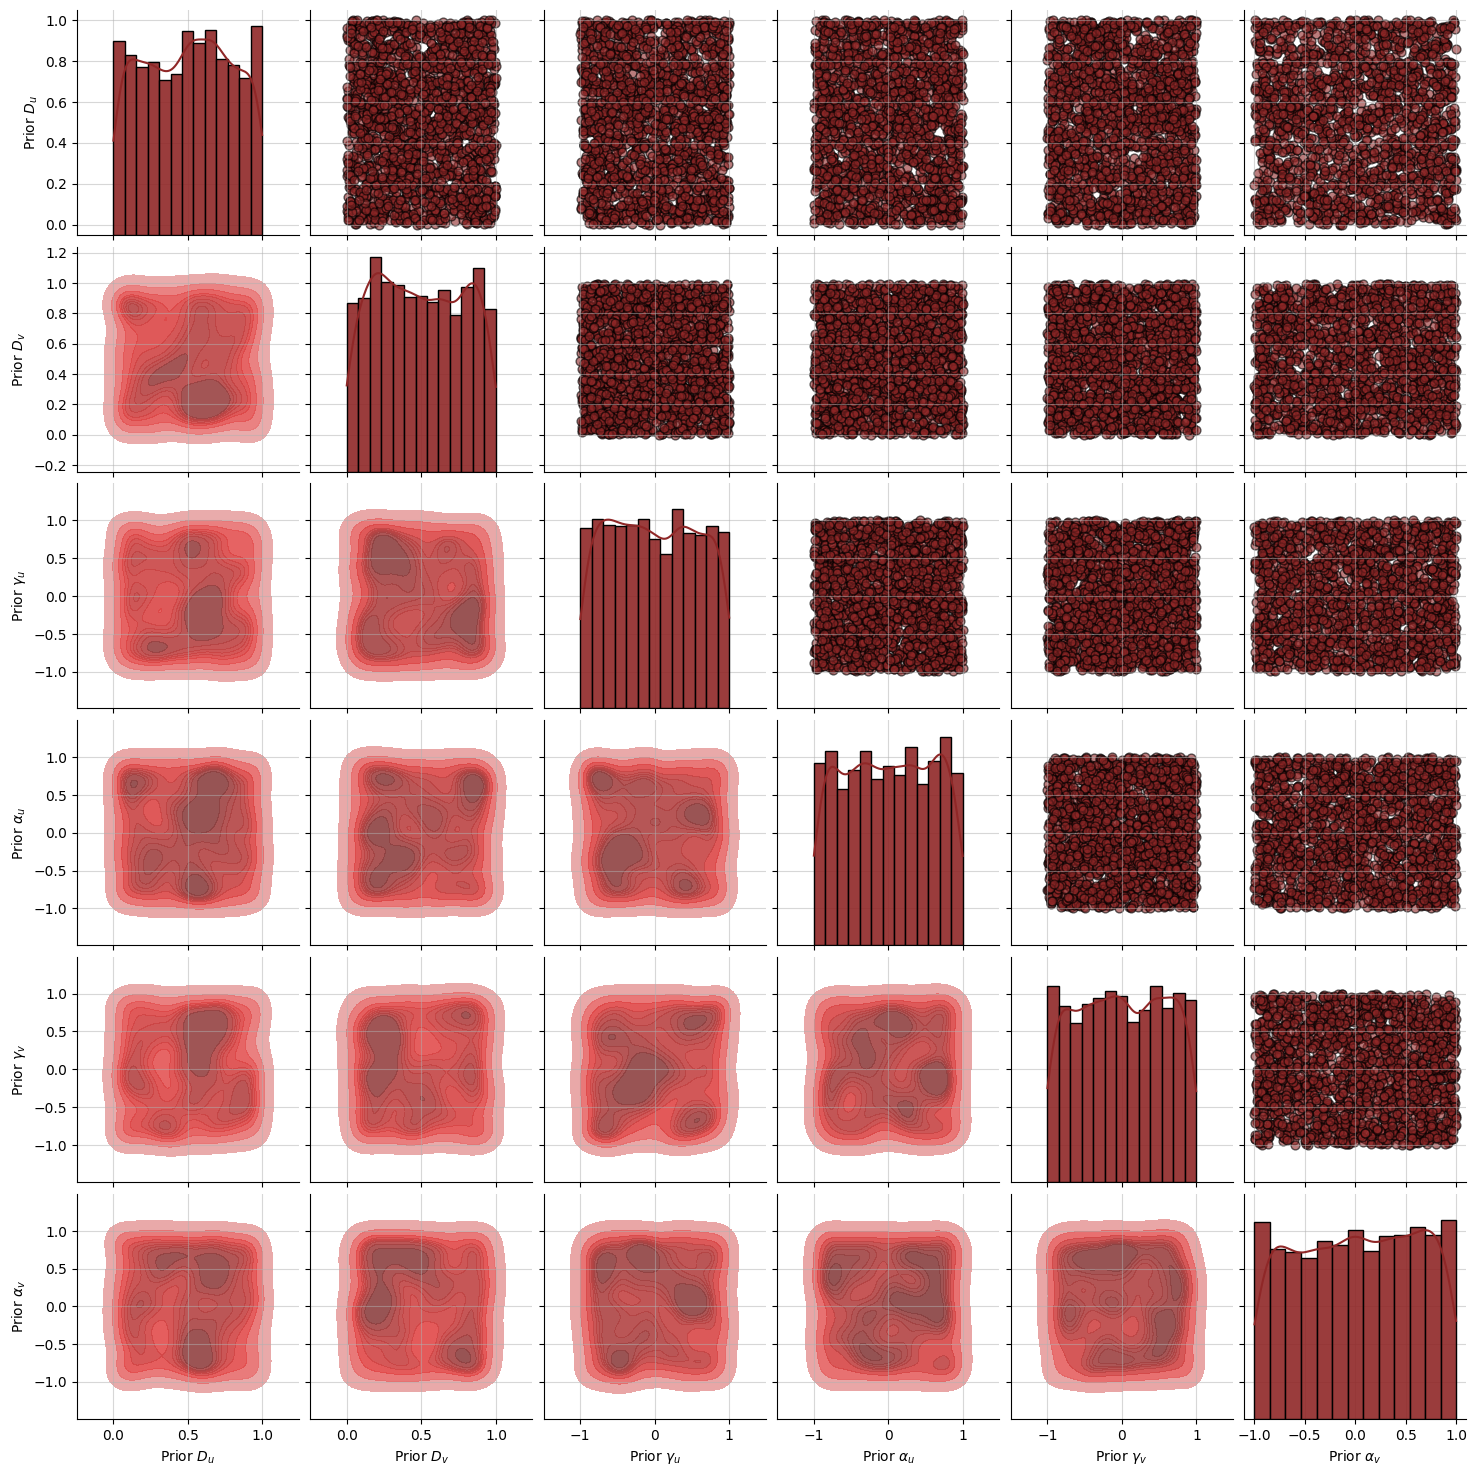

In [5]:
fig = prior.plot_prior2d()

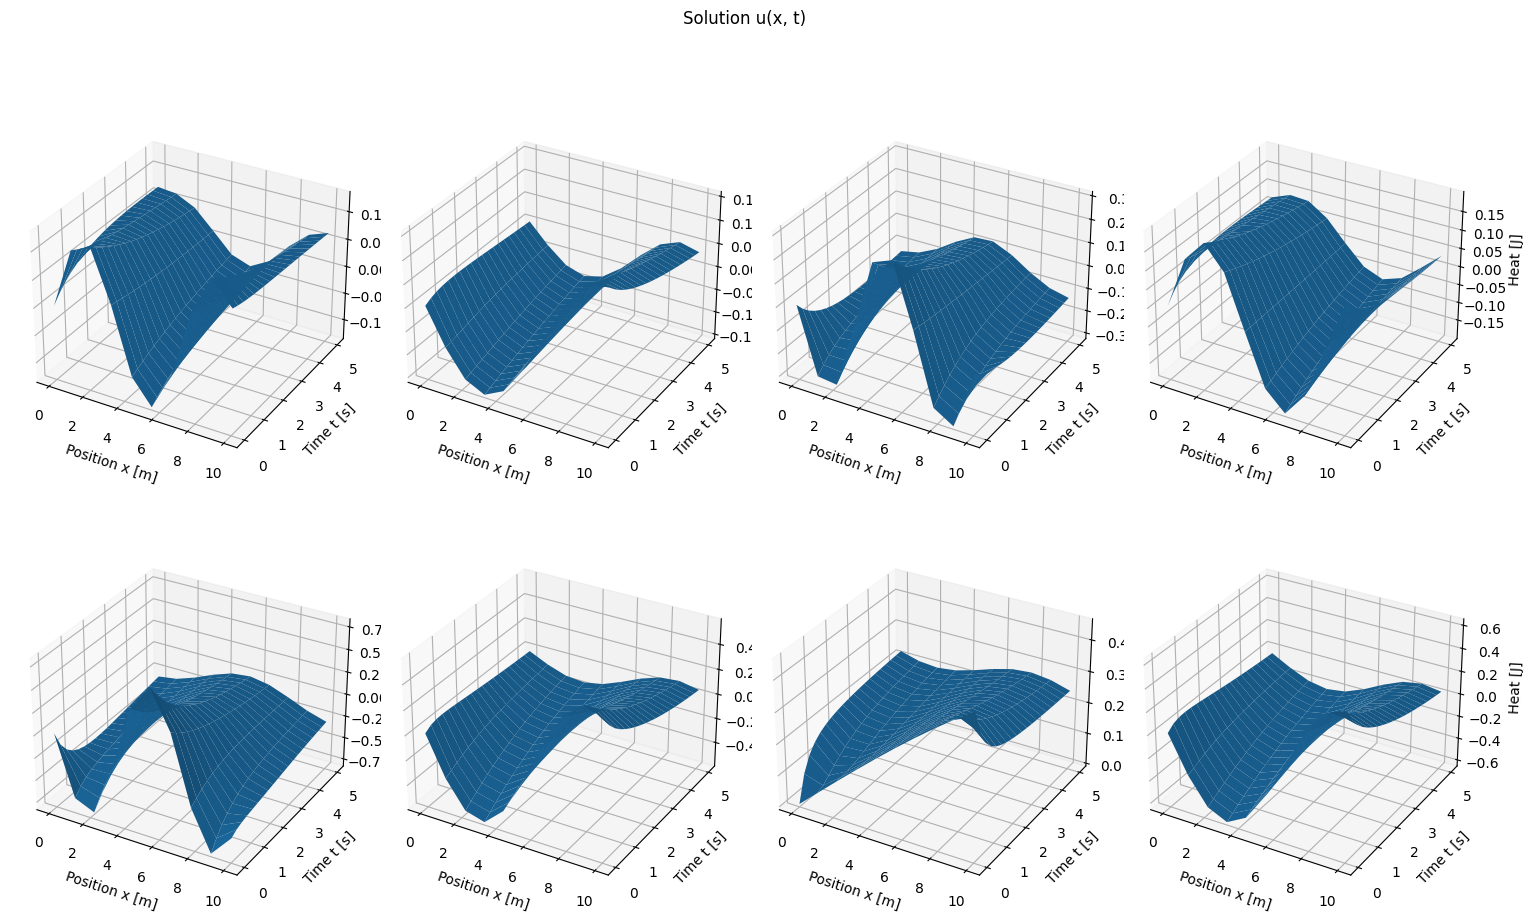

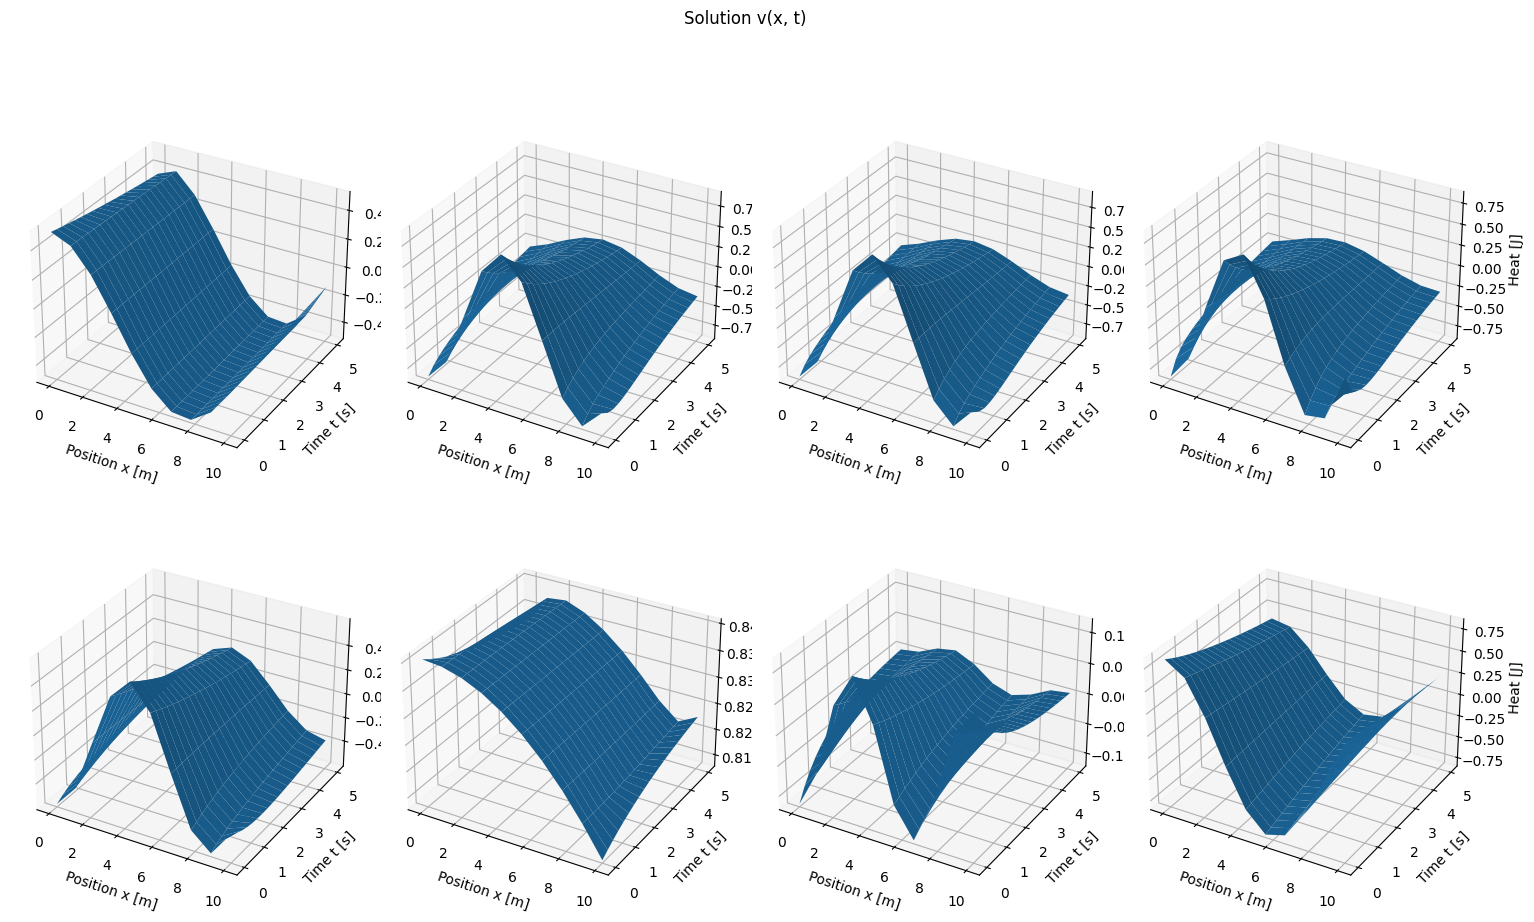

In [6]:
sim_data = model(8)['sim_data']

fig = plt.figure(figsize=(15, 10))
for i, data in enumerate(sim_data):
    ax = fig.add_subplot(int("24{}".format(i+1)), projection="3d")
    X, Y = np.meshgrid(x, t)
    mappable = plt.cm.ScalarMappable()
    mappable.set_array(sim_data[i, :, :len(x)])
    ax.plot_surface(X, Y, sim_data[i, :, :len(x)])
    ax.set_xlabel("Position x [m]")
    ax.set_ylabel("Time t [s]")
    ax.set_zlabel("Heat [J]")
fig.suptitle("Solution u(x, t)")
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure(figsize=(15, 10))
for i, data in enumerate(sim_data):
    ax = fig.add_subplot(int("24{}".format(i+1)), projection="3d")
    X, Y = np.meshgrid(x, t)
    mappable = plt.cm.ScalarMappable()
    mappable.set_array(sim_data[i, :, len(x):])
    ax.plot_surface(X, Y, sim_data[i, :, len(x):])
    ax.set_xlabel("Position x [m]")
    ax.set_ylabel("Time t [s]")
    ax.set_zlabel("Heat [J]")
fig.suptitle("Solution v(x, t)")
plt.tight_layout()
plt.show()
plt.close()
    

In [7]:
class LSTM(tf.keras.Model):
    def __init__(self, hidden_size=512, summary_dim=128):
        super(LSTM, self).__init__()
        
        self.LSTM = tf.keras.Sequential([
            tf.keras.layers.LSTM(hidden_size),
            tf.keras.layers.Dense(hidden_size, activation="relu"),
            tf.keras.layers.Dense(summary_dim, activation="sigmoid")
        ])
        
    def call(self, x, **kwargs):
        out = self.LSTM(x)
        return out
    
COUPLING_NET_SETTINGS = {
        't_args': {
            'dense_args': dict(units=128, kernel_initializer='glorot_uniform', activation='elu'),
            'num_dense': 2,
            'spec_norm': False,
            'mc_dropout': False,
            'dropout': False,
            'dropout_prob': 0.1
        },
        's_args': {
            'dense_args': dict(units=128, kernel_initializer='glorot_uniform', activation='elu'),
            'num_dense': 2,
            'spec_norm': False,
            'mc_dropout': False,
            'dropout': False,
            'dropout_prob': 0.1
        },
}
    
summary_net = LSTM()
inference_net = InvertibleNetwork(num_params=6, num_coupling_layers=10, coupling_net_settings=COUPLING_NET_SETTINGS)
amortizer = AmortizedPosterior(inference_net, summary_net, name="PDE_amortizer")

2023-02-09 10:35:02.298628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 10:35:02.365790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 10:35:02.367284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 10:35:02.369733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
data = model(batch_size=1000)
sim_mean = np.mean(data['sim_data'])
sim_std = np.std(data['sim_data'])

def configure_input(forward_dict):
    """Configures dictionary of prior draws and simulated data into BayesFlow format."""
    
    out_dict = {}
    
    # standardization sim_data
    sim_data = forward_dict['sim_data'].astype(np.float32)
    norm_data = (sim_data - sim_mean) / sim_std
    
    # standardization priors
    params = forward_dict['prior_draws'].astype(np.float32)
    norm_params = (params - prior_means) / prior_stds
    
    # remove nan, inf and -inf
    keep_idx = np.all(np.isfinite(norm_data), axis=(1, 2))
    if not np.all(keep_idx):
        print('Invalid value encountered...removing from batch')
        
    # add to dict
    out_dict['summary_conditions'] = norm_data[keep_idx]
    out_dict['parameters'] = norm_params[keep_idx]
    
    return out_dict

In [9]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input
)
amortizer.summary()

INFO:root:Performing a consistency check with provided components...
2023-02-09 10:35:11.399939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
INFO:root:Done.


Model: "PDE_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 1352040   
 bleNetwork)                                                     
                                                                 
 lstm (LSTM)                 multiple                  1419904   
                                                                 
Total params: 2,771,944
Trainable params: 2,771,824
Non-trainable params: 120
_________________________________________________________________


<br><br>
Note: For the purpose of this tutorial, we tried to restrict notebook runtime to around 20min (using Ryzen 7 and Nvidia GTX 1080). Better results with lower uncertainties can be achieved by increasing the number of training iterations and the representation capacities of both summary and inference network. 

In [10]:
%%time
losses = trainer.train_rounds(rounds=5, sim_per_round=3200, epochs=20, batch_size=32)

INFO:root:Simulating initial 3200 data sets for training...


Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 6400


Training epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 9600


Training epoch 1:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/300 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 12800


Training epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/400 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 16000


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 50s, sys: 47.8 s, total: 23min 37s
Wall time: 20min 25s


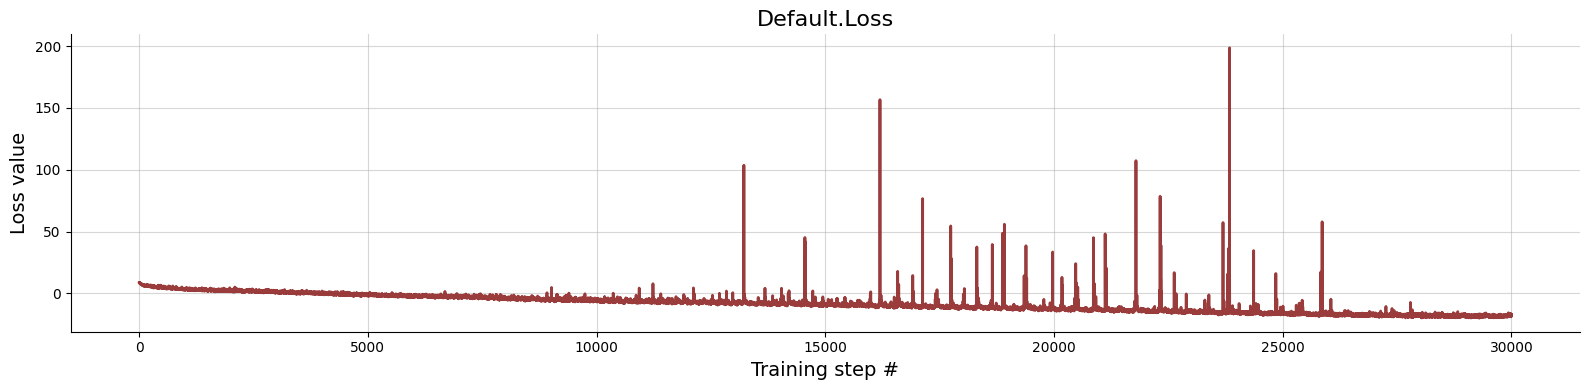

In [11]:
fig = diag.plot_losses(losses)

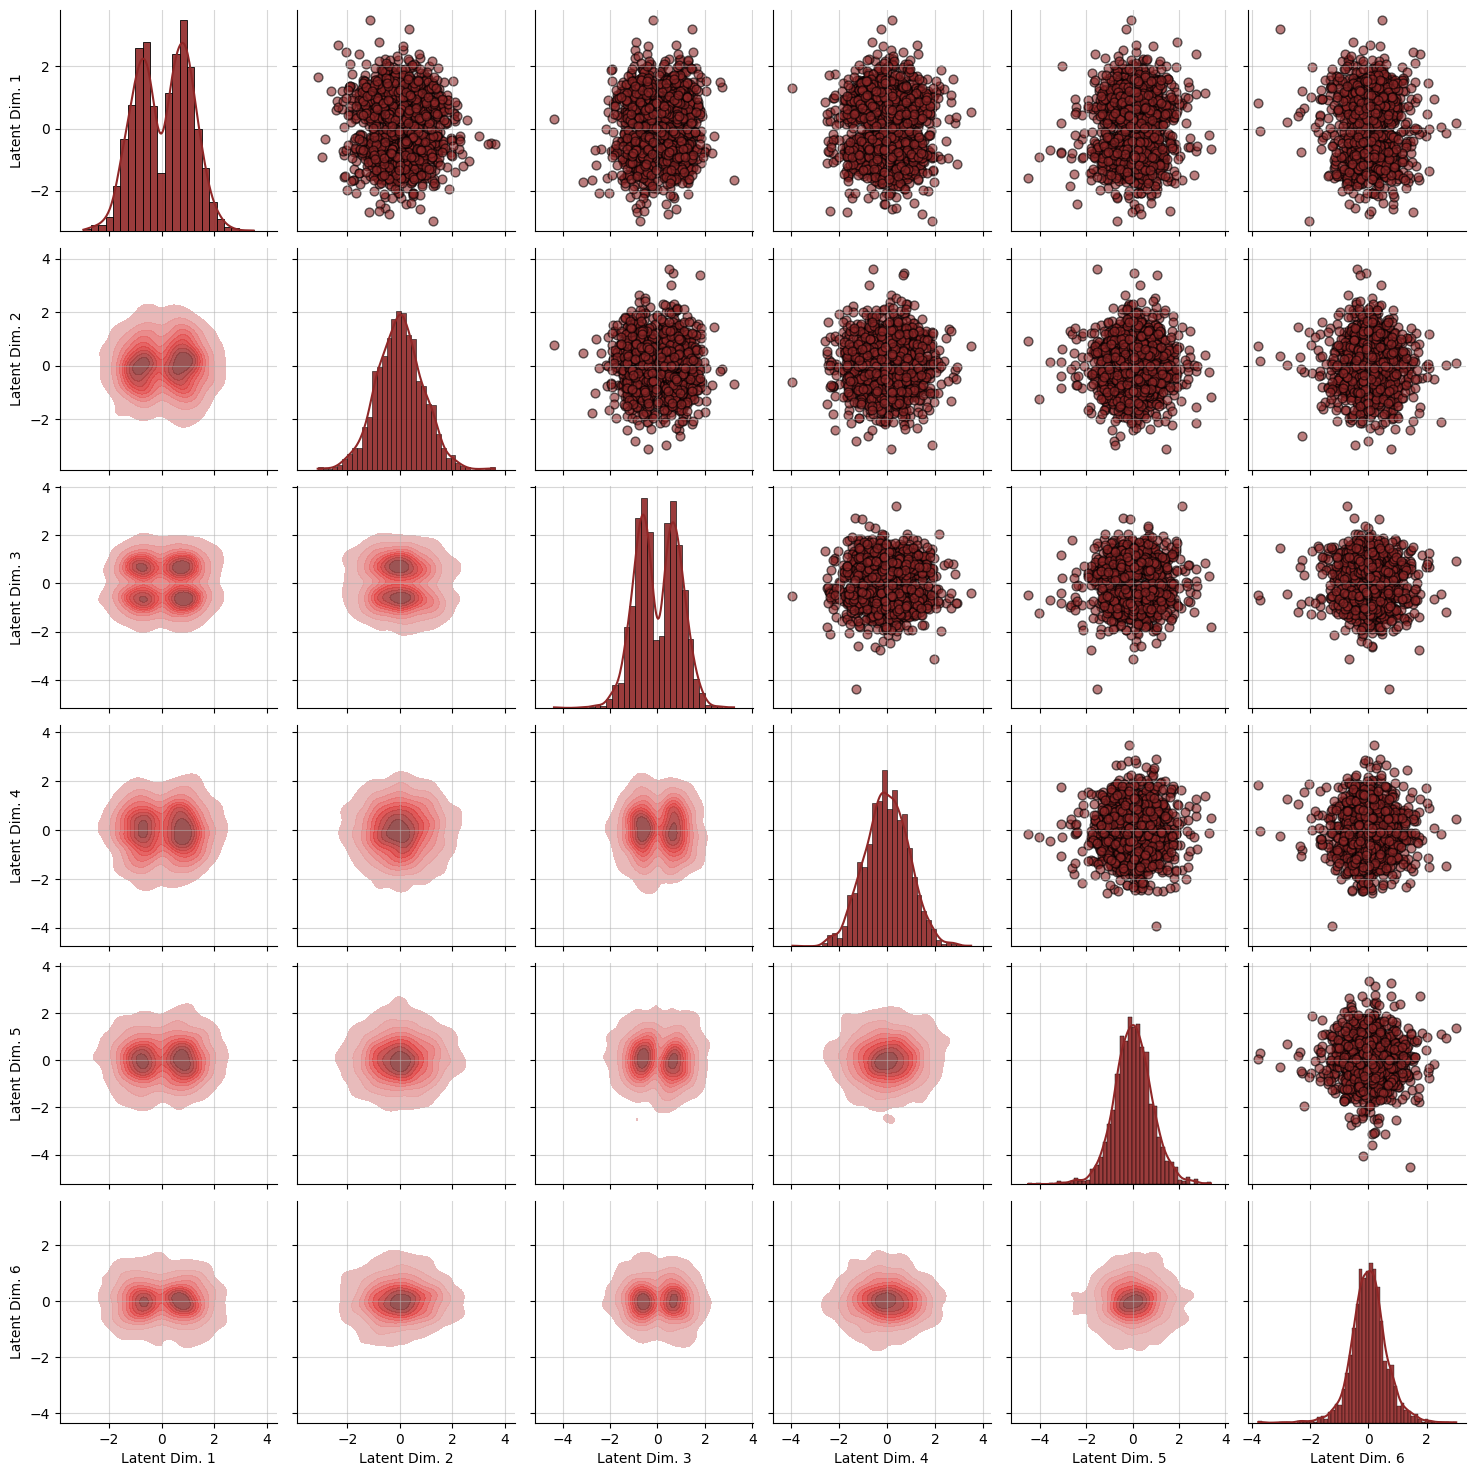

In [12]:
fig = trainer.diagnose_latent2d()

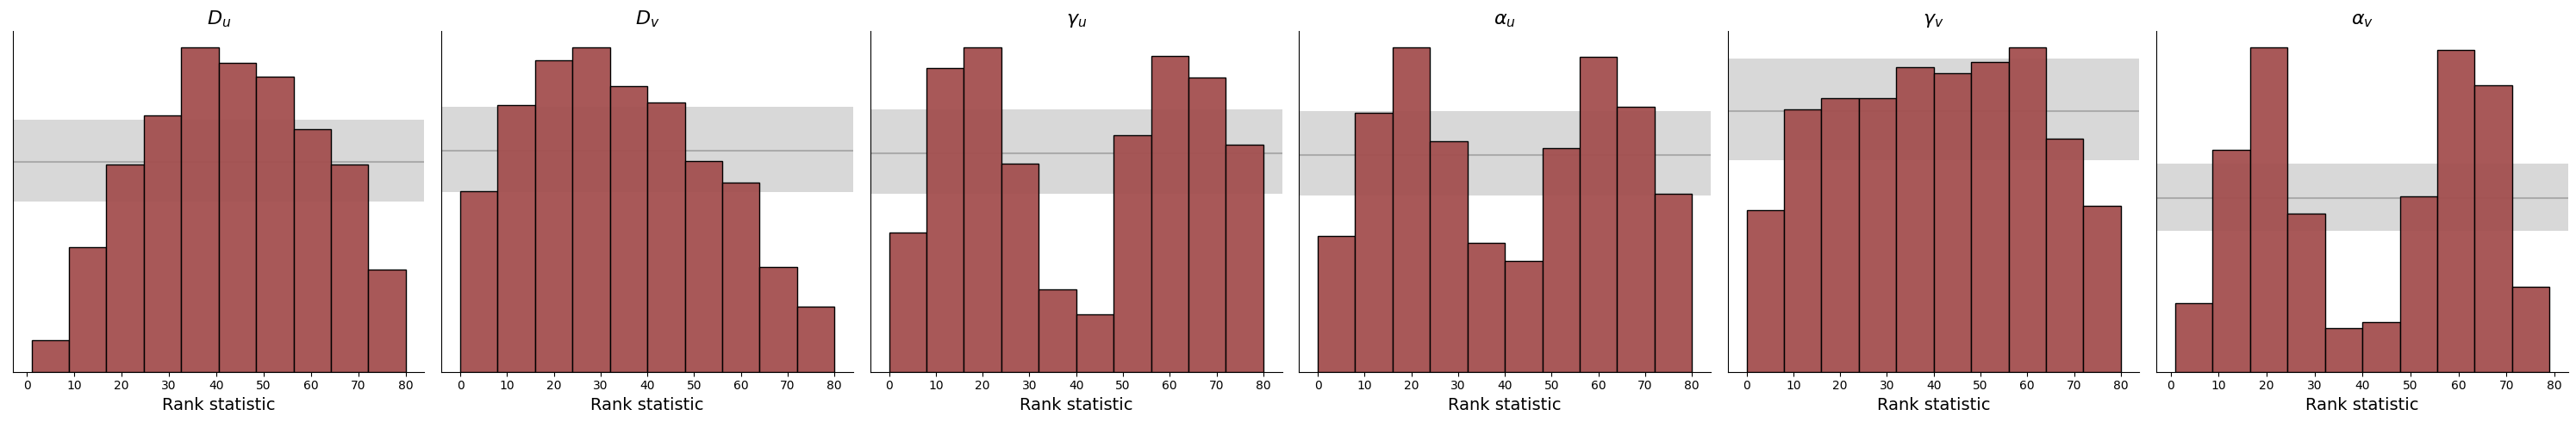

In [13]:
fig = trainer.diagnose_sbc_histograms()

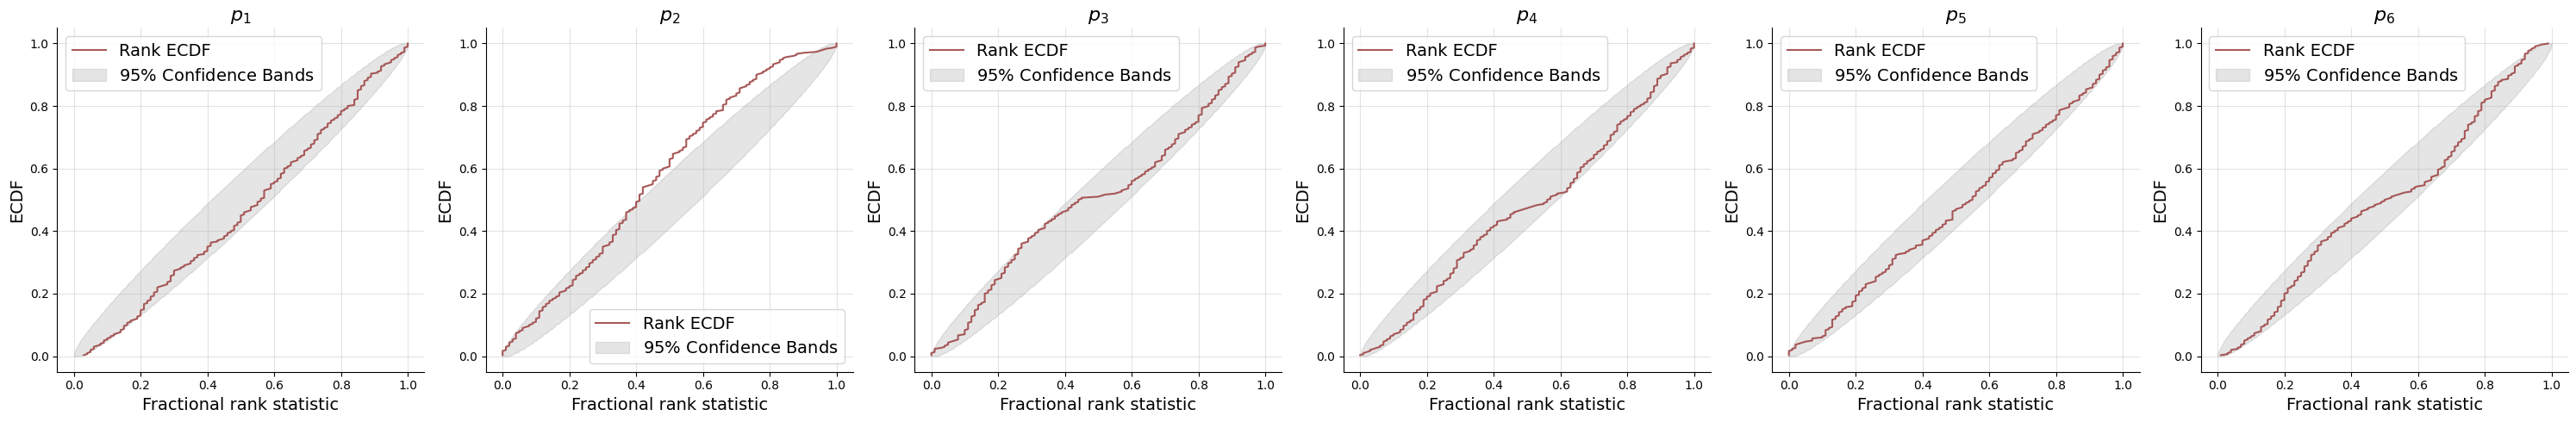

In [14]:
valid_sim_data_raw = model(batch_size=300)
valid_sim_data = trainer.configurator(valid_sim_data_raw)
posterior_samples = amortizer.sample(valid_sim_data, n_samples=100)
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['parameters'])

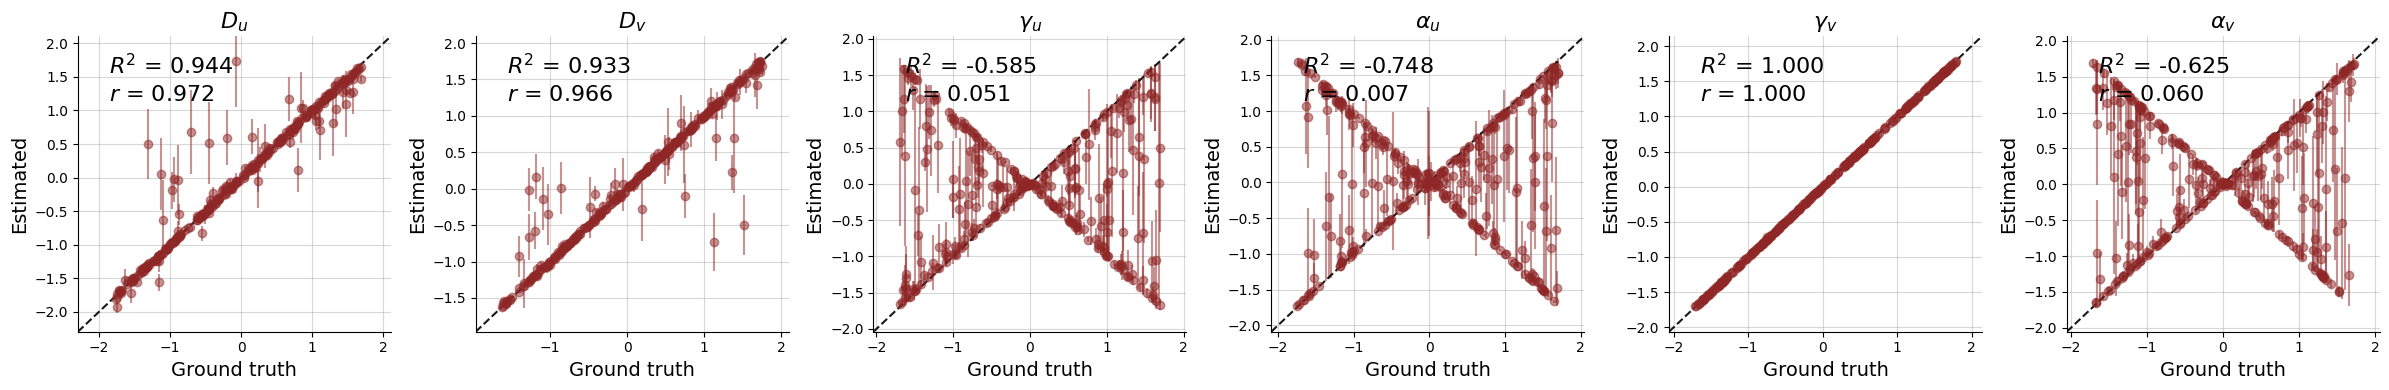

In [15]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['parameters'], param_names=prior.param_names)

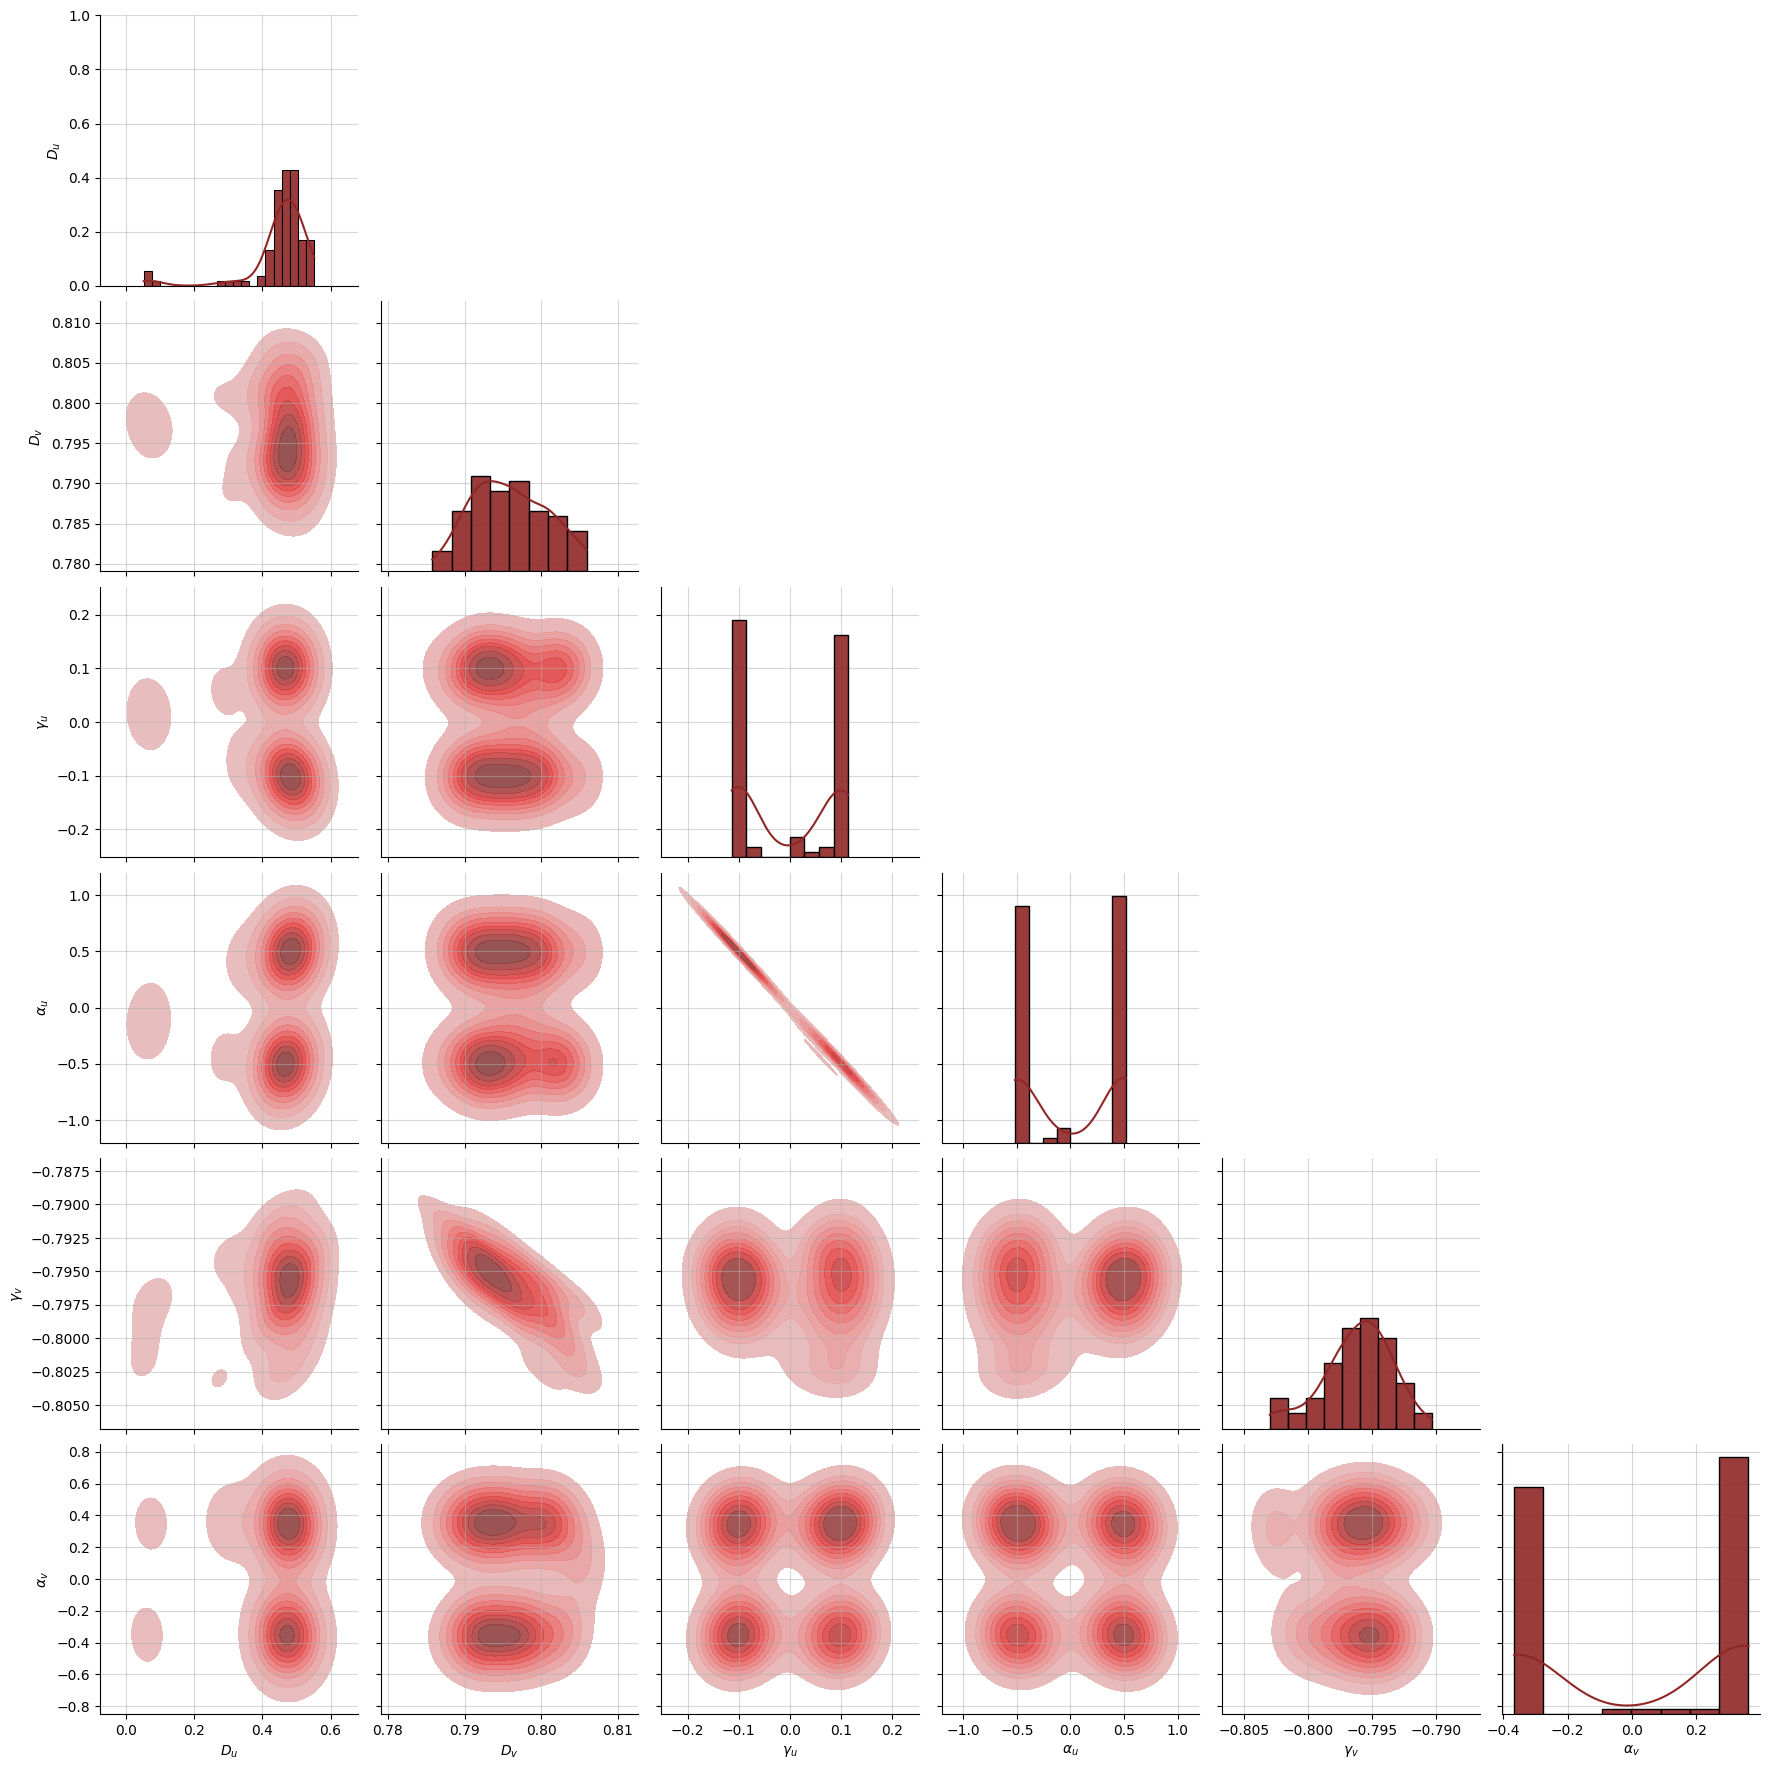

In [16]:
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], param_names=prior.param_names)

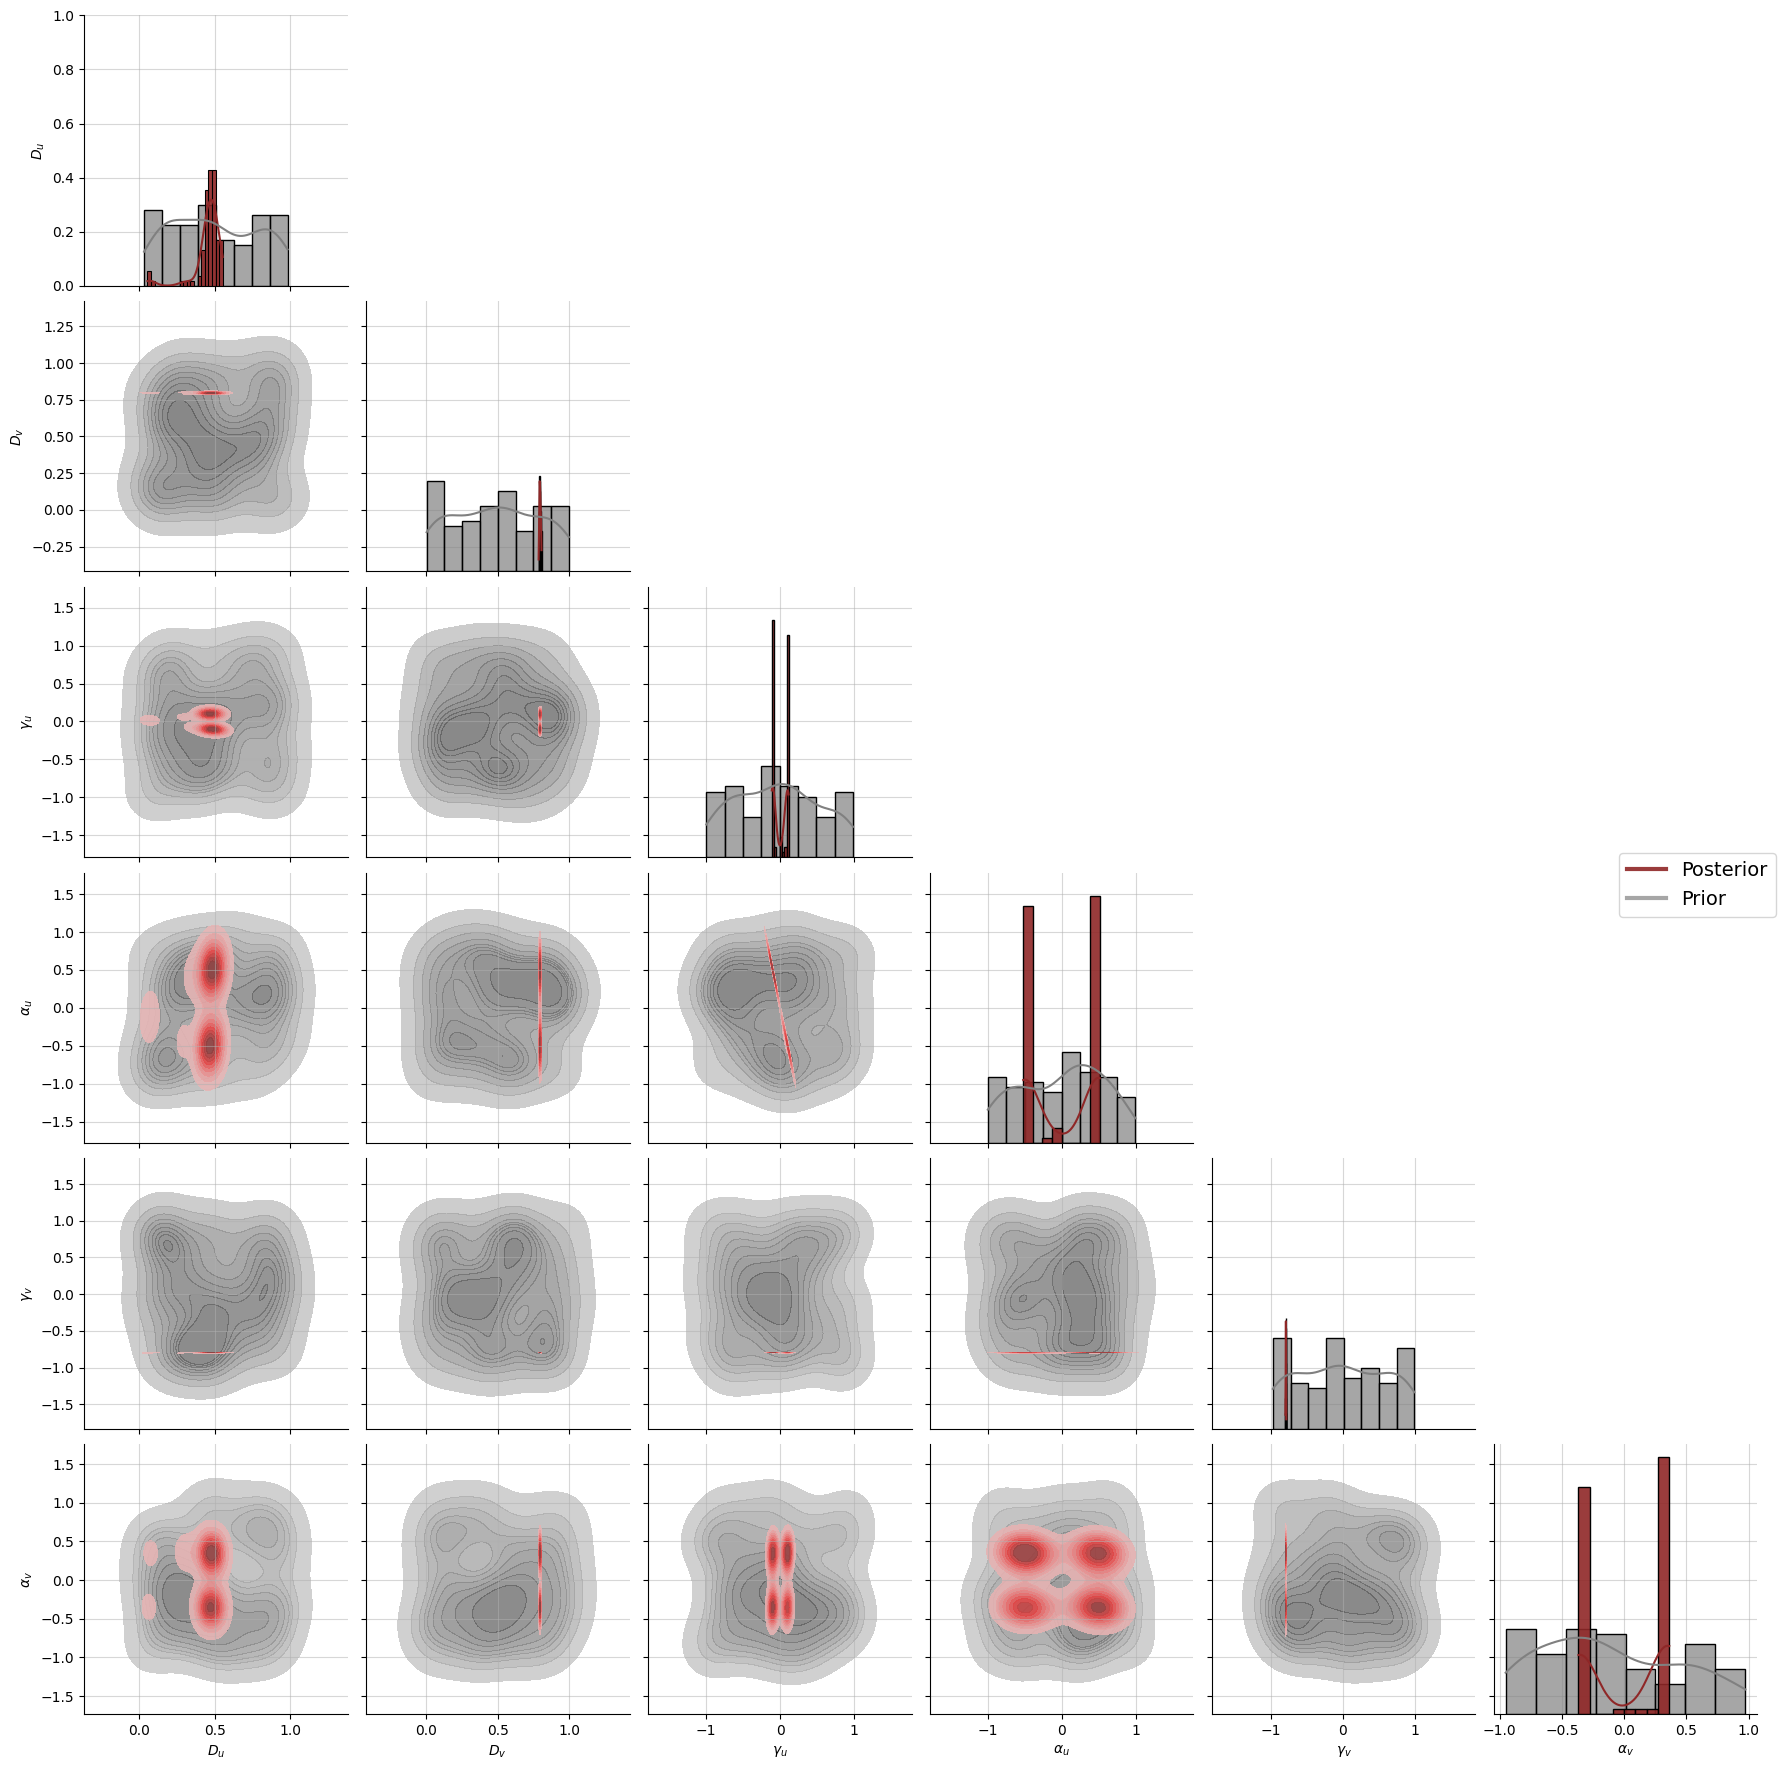

In [17]:
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior)

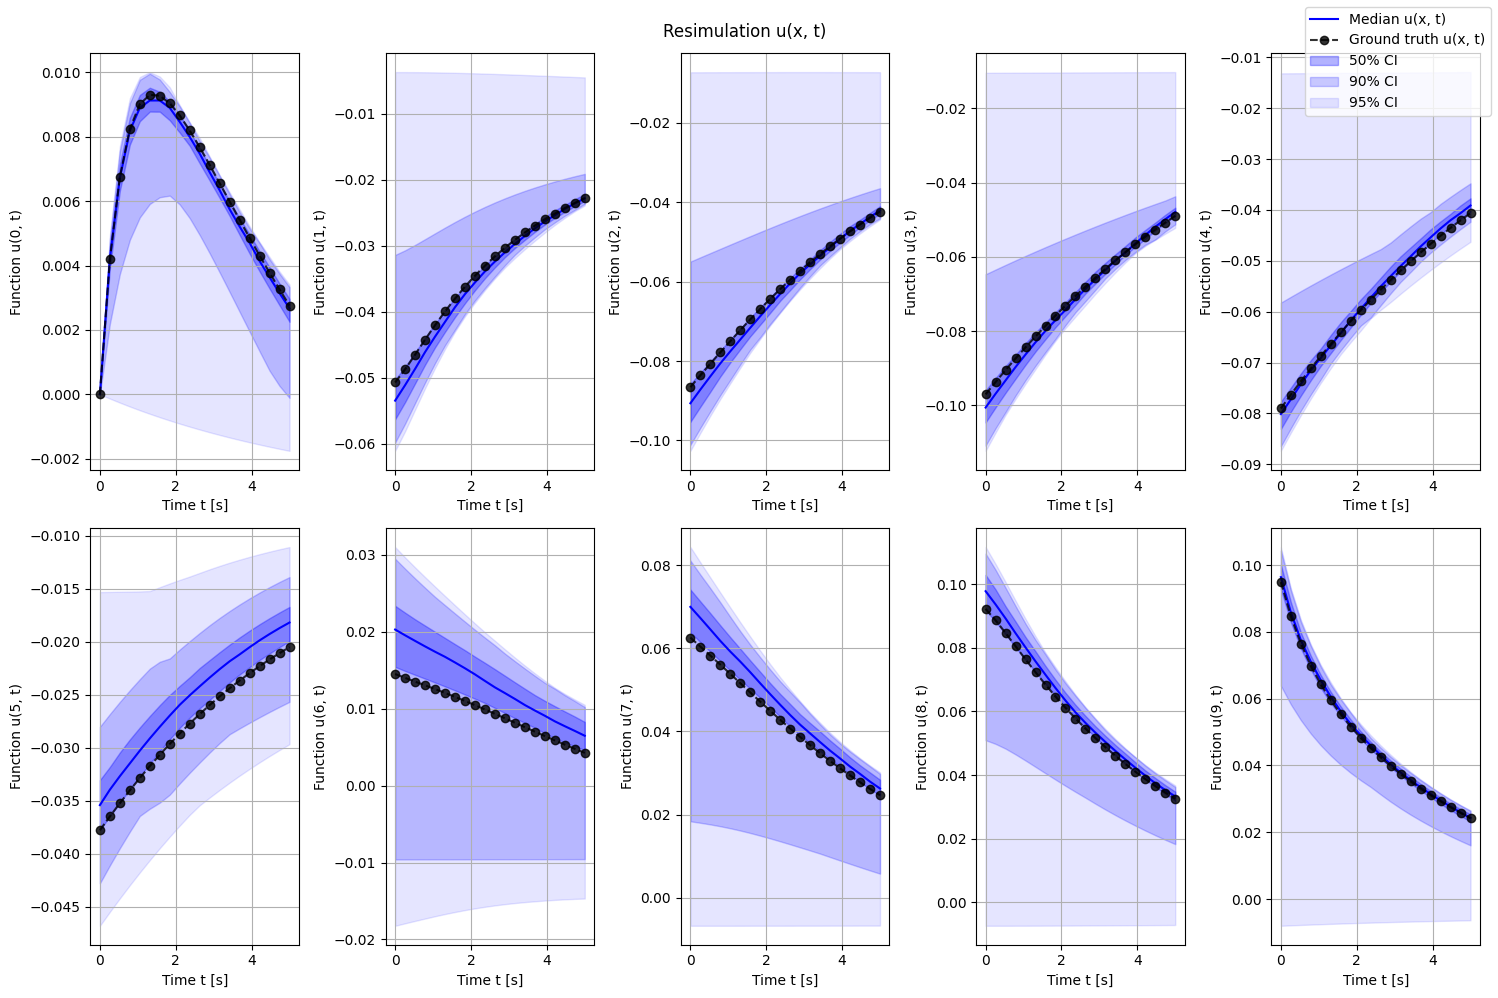

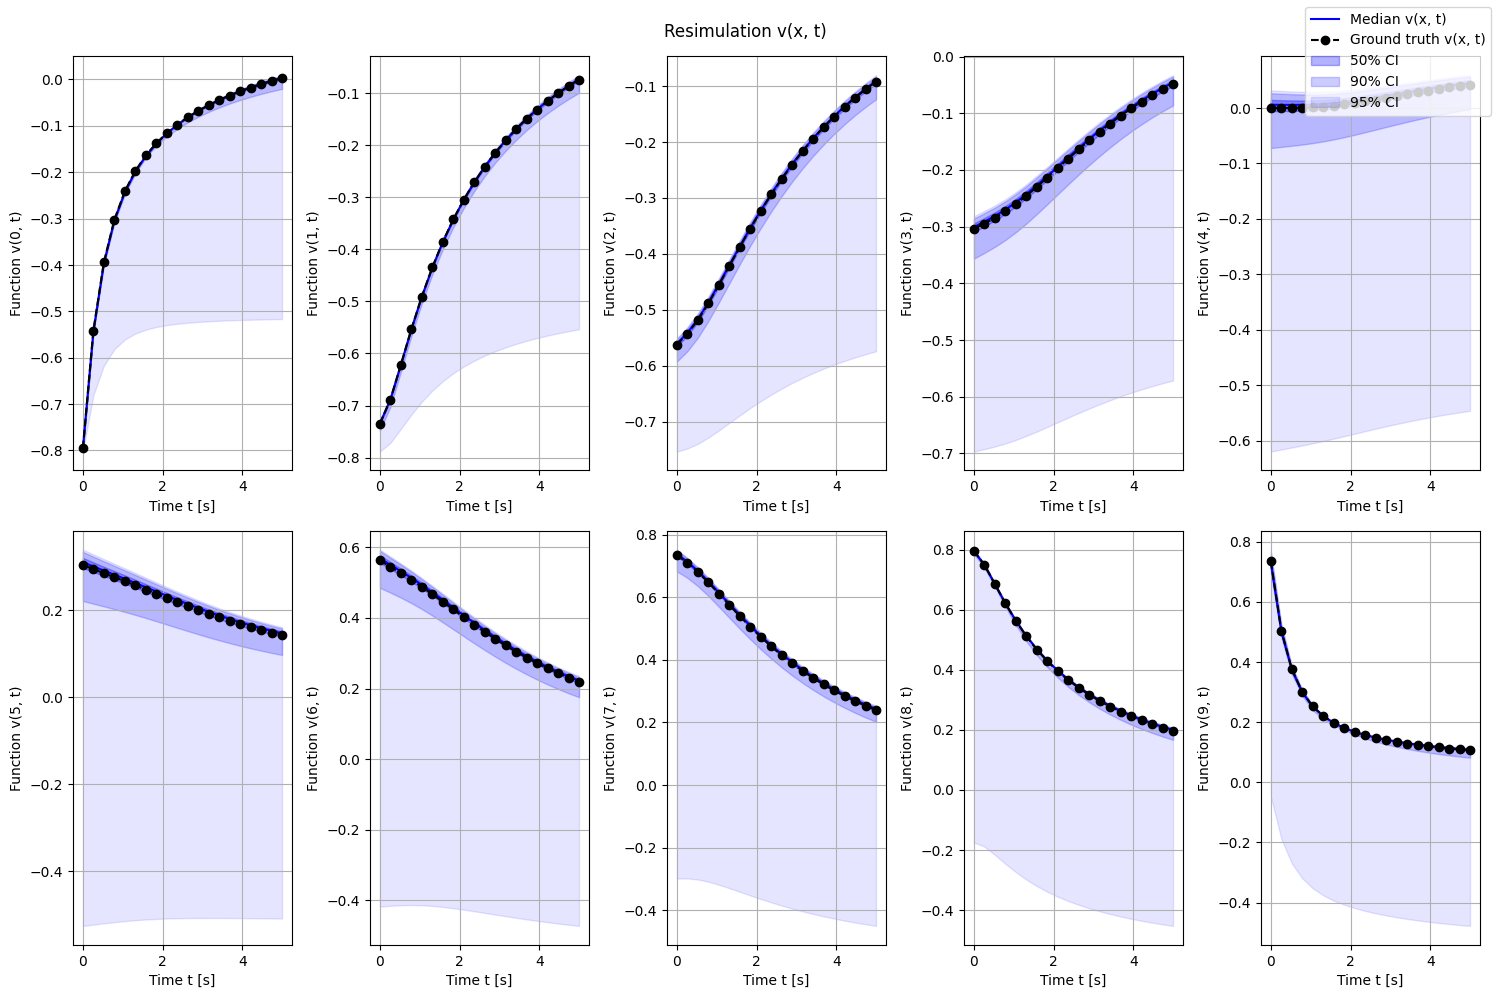

In [18]:
resim_u = np.empty((posterior_samples_unnorm[0].shape[0], len(t), len(x)), dtype=np.float32)
resim_v = np.empty((posterior_samples_unnorm[0].shape[0], len(t), len(x)), dtype=np.float32)

for i in range(posterior_samples_unnorm[0].shape[0]):
    re_sim = PDE_solver(posterior_samples_unnorm[0, i], t, x)
    resim_u[i, :, :] = re_sim[:, :len(x)]
    resim_v[i, :, :] = re_sim[:, len(x):]
    
fig = plt.figure(figsize=(15, 10))
for k in range(len(x)):
    ax = fig.add_subplot(2, 5, k+1)
    ax.plot(t, np.median(resim_u[:, :, k], axis=0), label='Median u(x, t)', color='b')
    ax.plot(t, valid_sim_data_raw['sim_data'][0, :, k], marker='o', label='Ground truth u(x, t)', color='k', linestyle='--', alpha=0.8)
    
    u_qt_50 = np.quantile(resim_u[:, :, k], q=[0.25, 0.75], axis=0)
    u_qt_90 = np.quantile(resim_u[:, :, k], q=[0.05, 0.95], axis=0)
    u_qt_95 = np.quantile(resim_u[:, :, k], q=[0.025, 0.975], axis=0)

    ax.fill_between(t, u_qt_50[0], u_qt_50[1], color='b', alpha=0.3, label="50% CI")
    ax.fill_between(t, u_qt_90[0], u_qt_90[1], color='b', alpha=0.2, label="90% CI")
    ax.fill_between(t, u_qt_95[0], u_qt_95[1], color='b', alpha=0.1, label="95% CI")

    ax.grid(True)
    ax.set_xlabel("Time t [s]")
    ax.set_ylabel("Function u({}, t)".format(k))
    handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
fig.suptitle("Resimulation u(x, t)")
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure(figsize=(15, 10))
for k in range(len(x)):
    ax = fig.add_subplot(2, 5, k+1)
    ax.plot(t, np.median(resim_v[:, :, k], axis=0), label='Median v(x, t)', color='b')
    ax.plot(t, valid_sim_data_raw['sim_data'][0, :, k+len(x)], marker='o', label='Ground truth v(x, t)', color='k', linestyle='--')
    
    v_qt_50 = np.quantile(resim_v[:, :, k], q=[0.25, 0.75], axis=0)
    v_qt_90 = np.quantile(resim_v[:, :, k], q=[0.05, 0.95], axis=0)
    v_qt_95 = np.quantile(resim_v[:, :, k], q=[0.025, 0.975], axis=0)
    
    ax.fill_between(t, v_qt_50[0], v_qt_50[1], color='b', alpha=0.3, label="50% CI")
    ax.fill_between(t, v_qt_90[0], v_qt_90[1], color='b', alpha=0.2, label="90% CI")
    ax.fill_between(t, v_qt_95[0], v_qt_95[1], color='b', alpha=0.1, label="95% CI")
    
    ax.grid(True)
    ax.set_xlabel("Time t [s]")
    ax.set_ylabel("Function v({}, t)".format(k))
    handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
fig.suptitle("Resimulation v(x, t)")
plt.tight_layout()
plt.show()
plt.close()   
